<a href="https://colab.research.google.com/github/stephiioo/datasci_6_anova/blob/main/datasci_6_anova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Preparation:

In [34]:
# bringing in data
from ucimlrepo import fetch_ucirepo

# bring in packages for dataframe + stats
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from scipy.stats import levene

# for visualization
import matplotlib.pyplot as plt

In [6]:
# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets


/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


## Research Question: How do the race of the patient (race) and their A1C test results (A1Cresult) jointly influence the duration of their hospital stay (time_in_hospital)?

## Factor 1 (Race - race): Caucasian, Asian, African American, Hispanic, Other

## Factor 2 (A1C test result - a1c): >8%, 7%, Normal, None (not measure)


## Variables of interest:

### Independent Variable 1: Race of patients (race)

### Independent Variable 2: A1C test result (A1Cresult)

### Dependent Variable: Duration hospital stay (time_in_hospital)

In [21]:
df = pd.DataFrame(X)
df

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,MC,NaN,...,No,No,Down,No,No,No,No,No,Ch,Yes
101762,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,MC,NaN,...,No,No,Steady,No,No,No,No,No,No,Yes
101763,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,...,No,No,Down,No,No,No,No,No,Ch,Yes
101764,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,...,No,No,Up,No,No,No,No,No,Ch,Yes


In [18]:
# Print column names
print(df.columns)

Index(['race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')


In [25]:
# Remove rows of missing 'race' values
df = df.dropna(subset=['race'])

# Convert to CSV file
df.to_csv('clean.csv')

In [23]:
unique_values = df['A1Cresult'].unique()
print(unique_values)

['None' '>7' '>8' 'Norm']


### cannot do a stats.shapiro with 'A1Cresult' because not all the data in df['A1Cresult'] is in a numeric or float format. Due to this, we will be using stats.shapiro with duration of hospital stay

In [29]:
# create a subset of the data that includes only the variables of interest
subset = df[['time_in_hospital', 'race', 'A1Cresult']]
subset

,time_in_hospital,race,A1Cresult
0,1,Caucasian,None
1,3,Caucasian,None
2,2,AfricanAmerican,None
3,2,Caucasian,None
4,1,Caucasian,None
...,...,...,...
101761,3,AfricanAmerican,>8
101762,5,AfricanAmerican,None
101763,1,Caucasian,None
101764,10,Caucasian,None


In [30]:
subset.dtypes

time_in_hospital     int64
race                object
A1Cresult           object
dtype: object

# 2. Assumption Test:

## Normality test:

In [26]:
stats.shapiro(df['time_in_hospital'])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8867098093032837, pvalue=0.0)

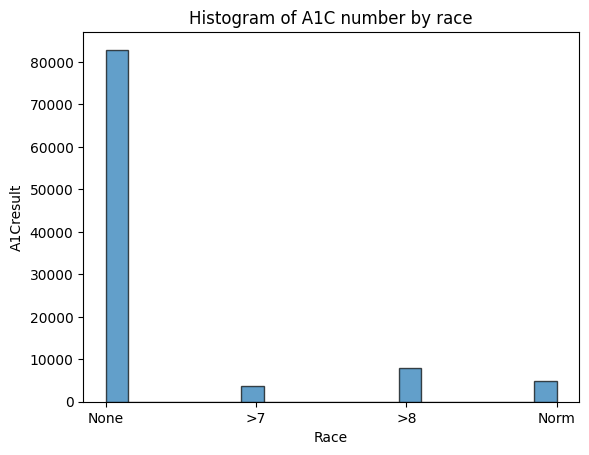

In [28]:
plt.hist(df['A1Cresult'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of A1C number by race')
plt.xlabel('Race')
plt.ylabel('A1Cresult')
plt.show()

### this shows that out variables are not normally distributed. this can be attributed to real-world complexity. real-world data is oftentimes influenced by a multitude of factors, making it complex and unlikely to conform to a simple, idealized distribution like the normal distribution.


### The p-value is "0.0" which means that there is a strong evidence to reject the null hypothesis and accept the alternative hypothesis.

## Homoscedasticity (Equal Variances):

In [36]:
groups = df.groupby(['race', 'A1Cresult'])

for (race_status, A1Cresult_status), group_df in groups:
    _, p_value = stats.shapiro(group_df['time_in_hospital'])

    print(f"Group ({race_status}, {A1Cresult_status}):")
    print(f"P-value from Shapiro-Wilk Test: {p_value}\n")


Group (AfricanAmerican, >7):
P-value from Shapiro-Wilk Test: 1.8906119489850806e-16

Group (AfricanAmerican, >8):
P-value from Shapiro-Wilk Test: 6.7359146155303186e-34

Group (AfricanAmerican, None):
P-value from Shapiro-Wilk Test: 0.0

Group (AfricanAmerican, Norm):
P-value from Shapiro-Wilk Test: 2.9696700824519264e-25

Group (Asian, >7):
P-value from Shapiro-Wilk Test: 0.0023467366117984056

Group (Asian, >8):
P-value from Shapiro-Wilk Test: 2.233798113593366e-05

Group (Asian, None):
P-value from Shapiro-Wilk Test: 2.6558121925662052e-21

Group (Asian, Norm):
P-value from Shapiro-Wilk Test: 0.0007482930086553097

Group (Caucasian, >7):
P-value from Shapiro-Wilk Test: 1.7925673399754353e-38

Group (Caucasian, >8):
P-value from Shapiro-Wilk Test: 0.0

Group (Caucasian, None):
P-value from Shapiro-Wilk Test: 0.0

Group (Caucasian, Norm):
P-value from Shapiro-Wilk Test: 1.930148504761003e-41

Group (Hispanic, >7):
P-value from Shapiro-Wilk Test: 2.1721559733123286e-06

Group (Hispanic

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [41]:
stats.levene(
    df['time_in_hospital'][df['race'] == 'AfricanAmerican'][df['A1Cresult'] == '>7'],
    df['time_in_hospital'][df['race'] == 'AfricanAmerican'][df['A1Cresult'] == '>8'],
    df['time_in_hospital'][df['race'] == 'AfricanAmerican'][df['A1Cresult'] == 'Norm'],
    df['time_in_hospital'][df['race'] == 'AfricanAmerican'][df['A1Cresult']== 'None'],
    df['time_in_hospital'][df['race'] == 'Other'][df['A1Cresult'] == '>7'],
    df['time_in_hospital'][df['race'] == 'Other'][df['A1Cresult'] == '>8'],
    df['time_in_hospital'][df['race'] == 'Other'][df['A1Cresult'] == 'Norm'],
    df['time_in_hospital'][df['race'] == 'Other'][df['A1Cresult'] == 'None'],
    df['time_in_hospital'][df['race'] == 'Caucasian'][df['A1Cresult'] == '>7'],
    df['time_in_hospital'][df['race'] == 'Caucasian'][df['A1Cresult'] == '>8'],
    df['time_in_hospital'][df['race'] == 'Caucasian'][df['A1Cresult'] == 'Norm'],
    df['time_in_hospital'][df['race'] == 'Caucasian'][df['A1Cresult'] == 'None'],
    df['time_in_hospital'][df['race'] == 'Asian'][df['A1Cresult'] == '>7'],
    df['time_in_hospital'][df['race'] == 'Asian'][df['A1Cresult'] == '>8'],
    df['time_in_hospital'][df['race'] == 'Asian'][df['A1Cresult'] == 'Norm'],
    df['time_in_hospital'][df['race'] == 'Asian'][df['A1Cresult'] == 'None'],
    df['time_in_hospital'][df['race'] == 'Hispanic'][df['A1Cresult'] == '>7'],
    df['time_in_hospital'][df['race'] == 'Hispanic'][df['A1Cresult'] == '>8'],
    df['time_in_hospital'][df['race'] == 'Hispanic'][df['A1Cresult'] == 'Norm'],
    df['time_in_hospital'][df['race'] == 'Hispanic'][df['A1Cresult'] == 'None'],
)

LeveneResult(statistic=7.4501020039258, pvalue=9.580811219790571e-21)

## the Levene test results in a very small p-value which implies that the assumption of equal variances among the groups being tested is not met.

## from this statistic, we would reject the null hypothesis. the null hypothesis of the Levene test is that the variances of the groups are equal.

## the extremely small p-value indicates that the variances are not equal among the groups. there is strong evidence to suggest that the groups have significantly different variances.

## 3. Conduct the ANOVA

In [42]:
model = ols('time_in_hospital ~ C(race) * C(A1Cresult)', data=df).fit()

# Performing the two-way ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                             sum_sq       df           F        PR(>F)
C(race)                  641.735130      4.0   18.075566  7.501203e-15
C(A1Cresult)            3895.231358      3.0  146.287793  1.363867e-94
C(race):C(A1Cresult)     276.823623     12.0    2.599070  1.845652e-03
Residual              882895.150091  99473.0         NaN           NaN


## for race, the p-value associated with the F-statistic for the "race" factor. since the p-value is very small (close to 0), it indicates that there is a significant effect of "race" on the dependent variable.

## the p-value associated with the F-statistic for the "A1Cresult" factor is also very small, indicating a significant effect of "A1Cresult" on the dependent variable.

## The small p-values for "race" and "A1Cresult" suggest that both factors have significant effects on the duration of time spent in the hospital, while the interaction effect is also significant, though possibly weaker.

## 4. Post-hoc test

In [47]:
from statsmodels.stats.multicomp import MultiComparison

In [49]:
post_hoc = MultiComparison(df['time_in_hospital'], df['race'])
tukey_result = post_hoc.tukeyhsd()
print(tukey_result)


      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
     group1       group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
AfricanAmerican     Asian  -0.5125 0.0002 -0.8396 -0.1855   True
AfricanAmerican Caucasian  -0.1221    0.0 -0.1879 -0.0564   True
AfricanAmerican  Hispanic   -0.448    0.0 -0.6378 -0.2582   True
AfricanAmerican     Other  -0.2343 0.0278 -0.4523 -0.0163   True
          Asian Caucasian   0.3904 0.0087  0.0673  0.7135   True
          Asian  Hispanic   0.0646 0.9894 -0.3043  0.4335  False
          Asian     Other   0.2783 0.2778 -0.1059  0.6624  False
      Caucasian  Hispanic  -0.3258    0.0 -0.5087  -0.143   True
      Caucasian     Other  -0.1121 0.5995 -0.3241  0.0998  False
       Hispanic     Other   0.2137 0.2175 -0.0631  0.4905  False
----------------------------------------------------------------


## when comparing "AfricanAmerican" to "Asian," the mean difference is approximately -0.5125 and the adjusted p-value is 0.0002, which is less than the significance level of 0.05. therefore, the null hypothesis of no difference between the "AfricanAmerican" and "Asian" groups is rejected, and it is concluded that there is a significant difference between these two groups.

## similarly, "AfricanAmerican" is compared to "Caucasian," "Hispanic," and "Other," and in each case, the adjusted p-value is less than 0.05, indicating significant differences.


## when comparing "Asian" to "Caucasian," the adjusted p-value is 0.0087, which is less than 0.05, so there is a significant difference.However, when comparing "Asian" to "Hispanic" and "Other," the adjusted p-values are greater than 0.05, so there are no significant differences.The same pattern continues for the comparisons involving "Caucasian," "Hispanic," and "Other" with other groups.

## to summarize, the table shows which group pairs have statistically significant differences in means after adjusting for multiple comparisons. "True" in the "reject" column indicates a significant difference, while "False" means no significant difference was found.

## there were no significant difficulties that arose while doing this assignment.